In [1]:
import wandb, pdb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style('dark')

In [48]:
api = wandb.Api(timeout=40)
runs = api.runs("structurelearning/structure-learning")
max_steps = 20000

In [49]:
def get_reqd_runs(exp_config):
    reqd_runs = []
    for run in runs:
        reqd_run = True
        for k,v in exp_config.items():
            if k not in run.config.keys() or run.config[k] != v: 
                reqd_run = False
                break
        if reqd_run is False: continue
        else: reqd_runs.append(run)   # This is a required run
        
    print(f"Fetched {len(reqd_runs)} runs")
    assert len(reqd_runs) == 20
    return reqd_runs


def get_plotting_data(reqd_runs, reqd_keys):
    seed_data = {}
    for key in reqd_keys: seed_data[key] = []

    for run in reqd_runs:
        plotting_data = run.scan_history(reqd_keys, max_steps)

        for key in reqd_keys:
            seed_data[key].append([data[key] for data in plotting_data])
    
    for key in reqd_keys:
        seed_data[key] = np.array([x for x in seed_data[key] if x])

    return seed_data


def get_plot_dataframe(d, n_interv_sets_list, exp_config, reqd_keys, exp_names):
    plot_data_dict = {
        'Graph density': [],
        'Data': [],
    }
    for key in reqd_keys:   plot_data_dict[key] = []

    for n_interv_sets in n_interv_sets_list:
        exp_config['n_interv_sets'] = n_interv_sets
        for exp_name in exp_names:
            exp_config['exp_name'] = exp_name
            reqd_runs = get_reqd_runs(exp_config)
            plotting_data = get_plotting_data(reqd_runs, reqd_keys)
            label = f"{n_interv_sets} types"
            for key in reqd_keys:
                num_seeds = len(plotting_data[key][:, -1])
                plot_data_dict[key] += (plotting_data[key][:, -1]).tolist()
            
            plot_data_dict['Graph density'] += [f'd={d}, ER-{int(exp_config["exp_edges"])}'] * num_seeds
            plot_data_dict['Data'] += [label] * num_seeds

    plot_df = pd.DataFrame(plot_data_dict)
    return plot_df


In [50]:
def plot_metrics_vs_interv_pts(d, plot_df, exp_edges_list, exp_names, reqd_keys, colors, 
                            figsize=(10, 10), fname=None, fontsize=100, width=0.5, 
                            xy_labelsize=10, bbox_to_anchor=[0.5,-0.08], 
                            methods=['Ours', 'Null graph']):
    is_d_list = False
    if isinstance(d, list): is_d_list = True
    assert len(colors) == len(methods)

    plt.rc('xtick', labelsize=xy_labelsize)
    plt.rc('ytick', labelsize=xy_labelsize)
    g = None
    lines_labels = []

    exp_names = np.array(exp_names)
    assert len(exp_names.shape) <= 2
    w = len(reqd_keys)

    if len(exp_names.shape) == 2 and exp_names.shape != (1, 1) and is_d_list is False:
        reqd_plot_dfs = plot_df
        h = 1
    else:
        reqd_plot_dfs = plot_df
        h = 1

    f, axes = plt.subplots(h, w, figsize = figsize )

    for i in range(len(reqd_plot_dfs)):
        reqd_plot_df = reqd_plot_dfs[i]

        for j in range(w):
            key = reqd_keys[j]
            if h == 1:  ax = axes[j]
            else:       ax = axes[i, j]
            remove_legend = True

            if key == 'Evaluations/SHD':
                if g is None:  remove_legend = False

                g = sns.boxplot(
                    ax=ax,
                    x="Graph density", 
                    y='Evaluations/SHD', 
                    data=reqd_plot_df[reqd_plot_df.Data.isin(methods)], 
                    hue='Data',
                    palette=colors,
                    width=width,
                    showfliers = False
                )

                if remove_legend is False:
                    lines_labels.append(ax.get_legend_handles_labels()) 
                
                ax.get_legend().remove()

            else:
                sns.boxplot(
                                ax=ax, 
                                x="Graph density", 
                                y=key, 
                                data=reqd_plot_df[reqd_plot_df.Data.isin(methods)], 
                                hue='Data',
                                palette=colors,
                                width=width,
                                showfliers = False
                            )
                ax.get_legend().remove()

            plt_name = key.split('/')[-1]
            if plt_name == 'L_MSE': plt_name = r'MSE($L$, $\hat{L}$)'
            if plt_name == 'MCC':   plt_name = r'MCC($z$, $\hat{z}$)'

            if i == 0:
                ax.set_title(plt_name, fontsize=fontsize)
                if is_d_list is False:
                    ax.get_xaxis().set_visible(False)
            
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.grid(axis='y')
            ax.tick_params(labelrotation=20)

    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    lgd = f.legend(lines, labels, ncol=len(labels), loc='lower center', bbox_to_anchor=bbox_to_anchor, fontsize=xy_labelsize)
    plt.tight_layout()
    f.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    print(f'Saved figure: {fname}')
    plt.show()
    plt.close('all')

In [51]:
def get_boxplot_d(d, n_interv_sets_list, exp_names_list, exp_config, reqd_keys, exp_edges_list, fname, 
                colors=['#ea4335', '#f4b400', '#4c8bf5'], figsize=(15, 6), fontsize=18, width=0.4, 
                xy_labelsize=14, bbox_to_anchor=[0.0, 0.0], methods=['Ours', 'Null graph']):

    plot_df_list = []
    is_d_list = False
    if isinstance(d, list): 
        is_d_list = True
        exp_names_list = [exp_names_list[0]]
        for d_i in d:
            exp_config['num_nodes'] = d_i
            plot_df = get_plot_dataframe(d_i, exp_config, reqd_keys, exp_edges_list, exp_names_list[0])
            plot_df_list.append(plot_df)
    else:
        for exp_names in exp_names_list:
            plot_df = get_plot_dataframe(d, n_interv_sets_list, exp_config, reqd_keys, exp_names)
            plot_df_list.append(plot_df)
    
    plot_metrics_vs_interv_pts(d, 
                            plot_df_list, 
                            exp_edges_list,
                            exp_names_list,
                            reqd_keys,
                            colors=colors,
                            figsize=figsize, 
                            fname=fname,
                            fontsize=fontsize,
                            width=width,
                            xy_labelsize=xy_labelsize,
                            bbox_to_anchor=bbox_to_anchor,
                            methods=methods)

    return plot_df_list

## Linear LBCD

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: outputs/linear/d5_vs_interv_types_linear_dbcd.pdf


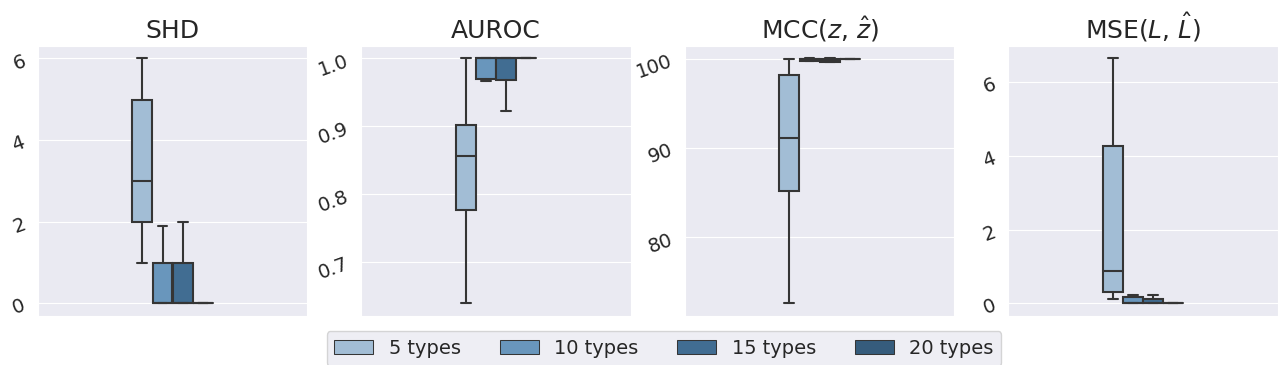

In [39]:
d = 5
exp_config = {
    'exp_name': 'Decoder BCD multi interventional learn L (linear projection)',
    'num_nodes': d,
    'exp_edges': 1.0,
    'n_interv_sets': 20,
    'pts_per_interv': 100
}
exp_edges_list = [1.0]
exp_names_list = [[ 'Decoder BCD multi interventional learn L (linear projection)' ]]

reqd_keys = [   'Evaluations/SHD', 
                'Evaluations/AUROC', 
                'Evaluations/MCC', 
                'L_MSE']

n_interv_sets_list = [5, 10, 15, 20]

d5_linear_dbcd = get_boxplot_d(d, n_interv_sets_list, exp_names_list, exp_config, 
                                reqd_keys, exp_edges_list, 
                                f'outputs/linear/d{d}_vs_interv_types_linear_dbcd.pdf',
                                bbox_to_anchor=[0.415, -0.03],
                                colors=['#99bede', '#5b97ca', '#336ea0', '#2b5d87'],
                                methods=[f'{i} types' for i in n_interv_sets_list],
                                width=0.3,
                                figsize=(16,3.5))

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: outputs/linear/d10_vs_interv_types_linear_dbcd.pdf


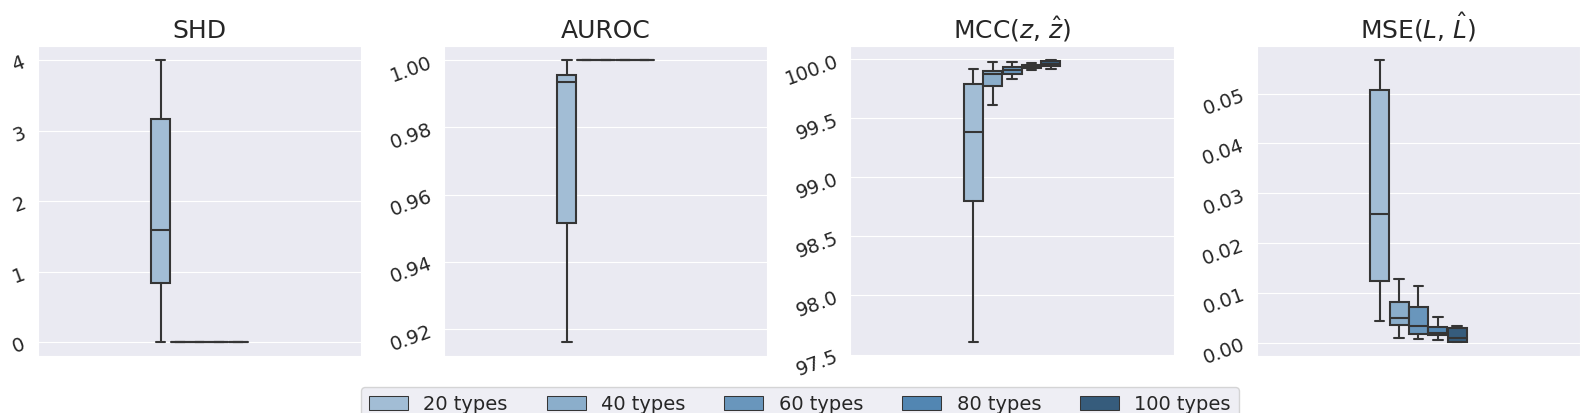

In [47]:
d = 10
exp_config = {
    'exp_name': 'Batched Decoder BCD multi interventional learn L (linear projection)',
    'num_nodes': d,
    'exp_edges': 1.0,
    'pts_per_interv': 100
}
exp_edges_list = [1.0]
exp_names_list = [[ 'Batched Decoder BCD multi interventional learn L (linear projection)' ]]

reqd_keys = [   'Evaluations/SHD', 
                'Evaluations/AUROC', 
                'Evaluations/MCC', 
                'L_MSE'  ]

n_interv_sets_list = [20, 40, 60, 80, 100]

d5_linear_dbcd = get_boxplot_d(d, n_interv_sets_list, exp_names_list, exp_config, 
                                reqd_keys, exp_edges_list, 
                                f'outputs/linear/d{d}_vs_interv_types_linear_dbcd.pdf',
                                bbox_to_anchor=[0.5, -0.045],
                                colors=['#99bede', '#80afd6', '#5b97ca', '#4288c2', '#2b5d87'],
                                methods=[f'{i} types' for i in n_interv_sets_list],
                                width=0.3,
                                figsize=(16,4))

## Nonlinear BCD

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: outputs/nonlinear/d5_vs_interv_types_nonlinear_dbcd.pdf


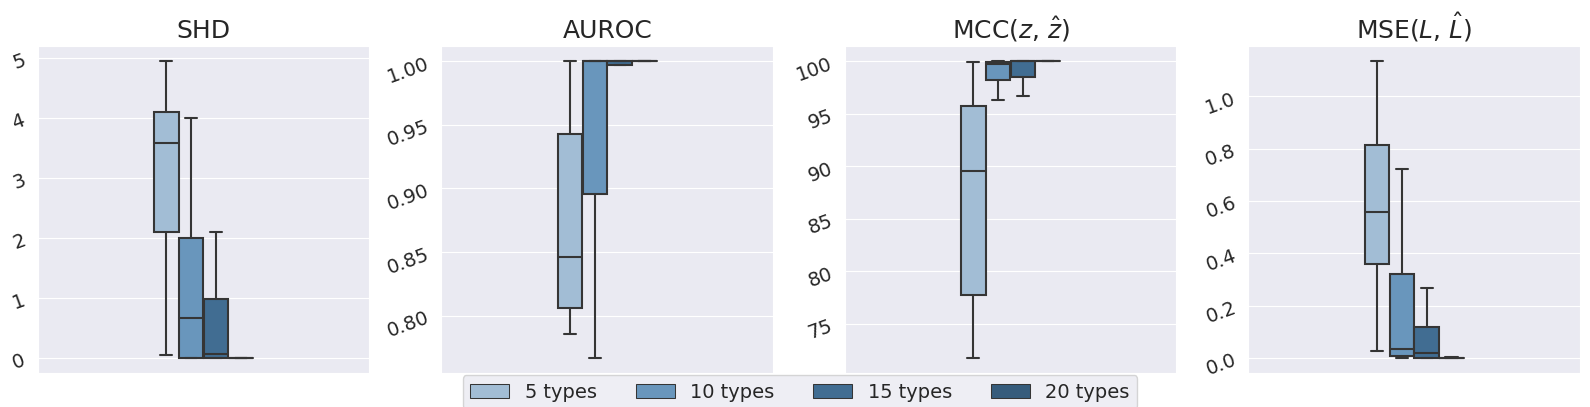

In [53]:
d = 5
exp_config = {
    'exp_name': 'Decoder BCD multi interventional learn L (nonlinear projection)',
    'num_nodes': d,
    'exp_edges': 1.0,
    'pts_per_interv': 100
}
exp_edges_list = [1.0]
exp_names_list = [[ 'Decoder BCD multi interventional learn L (nonlinear projection)' ]]

reqd_keys = [   'Evaluations/SHD', 
                'Evaluations/AUROC', 
                'Evaluations/MCC', 
                'L_MSE'  ]

n_interv_sets_list = [5, 10, 15, 20]

d5_linear_dbcd = get_boxplot_d(d, n_interv_sets_list, exp_names_list, exp_config, 
                                reqd_keys, exp_edges_list, 
                                f'outputs/nonlinear/d{d}_vs_interv_types_nonlinear_dbcd.pdf',
                                bbox_to_anchor=[0.5, -0.03],
                                colors=['#99bede', '#5b97ca', '#336ea0', '#2b5d87'],
                                methods=[f'{i} types' for i in n_interv_sets_list],
                                width=0.3,
                                figsize=(16,4))

Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Fetched 20 runs
Saved figure: outputs/nonlinear/d10_vs_interv_types_nonlinear_dbcd.pdf


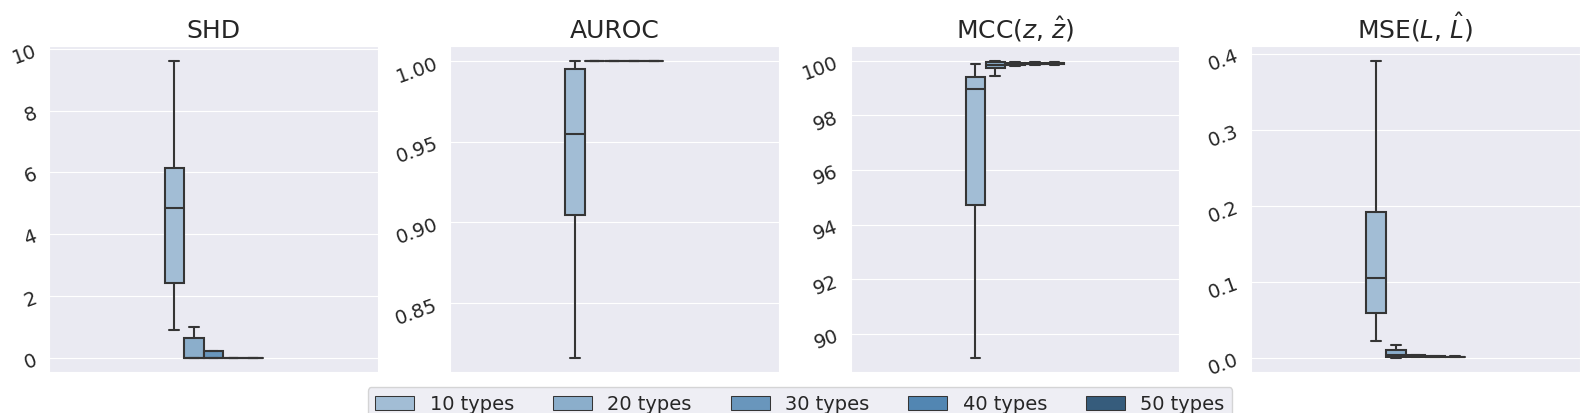

In [54]:
d = 10
exp_config = {
    'exp_name': 'Decoder BCD multi interventional learn L (nonlinear projection)',
    'num_nodes': d,
    'exp_edges': 1.0,
    'pts_per_interv': 100
}
exp_edges_list = [1.0]
exp_names_list = [[ 'Decoder BCD multi interventional learn L (nonlinear projection)' ]]

reqd_keys = [   'Evaluations/SHD', 
                'Evaluations/AUROC', 
                'Evaluations/MCC', 
                'L_MSE'  ]

n_interv_sets_list = [10, 20, 30, 40, 50]

d5_linear_dbcd = get_boxplot_d(d, n_interv_sets_list, exp_names_list, exp_config, 
                                reqd_keys, exp_edges_list, 
                                f'outputs/nonlinear/d{d}_vs_interv_types_nonlinear_dbcd.pdf',
                                bbox_to_anchor=[0.5, -0.045],
                                colors=['#99bede', '#80afd6', '#5b97ca', '#4288c2', '#2b5d87'],
                                methods=[f'{i} types' for i in n_interv_sets_list],
                                width=0.3,
                                figsize=(16,4))